In [28]:
# -*- coding: utf-8 -*-
"""
[Ian, Noriega]
[10145657]
[MMA]
[2021W]
[MMA865]
[October 18th, 2020]


Submission to Question 2, Part 1
"""

'\n[Ian, Noriega]\n[10145657]\n[MMA]\n[2021W]\n[MMA865]\n[October 18th, 2020]\n\n\nSubmission to Question 2, Part 1\n'

In [29]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Import

In [627]:
#import training data
df = pd.read_csv("sentiment_train.csv")

In [628]:
#check out the data
df.info()
df.head()
#observations: 2202 sentences, no missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2202 entries, 0 to 2201
Data columns (total 2 columns):
Sentence    2202 non-null object
Polarity    2202 non-null int64
dtypes: int64(1), object(1)
memory usage: 34.5+ KB


,Sentence,Polarity
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


## EDA

In [629]:
#let's check out our target (polarity)
np.bincount(df['Polarity'])

array([1113, 1089], dtype=int64)

0    0.50545
1    0.49455
Name: Polarity, dtype: float64

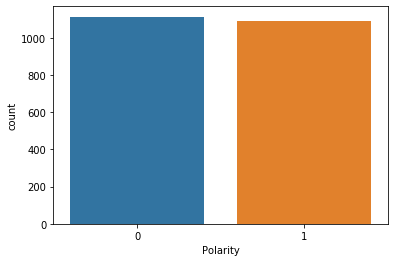

In [630]:
#visualize
sns.countplot(x = 'Polarity', data = df)

df['Polarity'].value_counts(normalize=True)

#observations: looks like no target imbalance here, nearly a perfect 50/50 split between positive and negative sentences

## Train/Test Split

In [66]:
from sklearn.model_selection import train_test_split

X = df['Sentence']
y = df['Polarity']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1024)

In [67]:
#preview X_train
X_train.head()

986     Shrimp- When I unwrapped it (I live only 1/2 a...
575     The pizza tasted old, super chewy in not a goo...
694     Hawaiian Breeze, Mango Magic, and Pineapple De...
1199                          useless phone, simply deaf.
2122    Maybe there would be a reasonable explanation ...
Name: Sentence, dtype: object

## Text Preprocessing

In [441]:
#import libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.lancaster import LancasterStemmer
import re
import unidecode
import string

In [442]:
#define preprocessing function

lemmer = WordNetLemmatizer()

def preprocess(doc):

    doc = doc.lower() #lower case everything
        
    doc = unidecode.unidecode(doc)
    
    doc = re.sub(r'\b\d+\b', 'NUM', doc) #replace numbers with the string "NUM"
    
    doc = ' '.join([lemmer.lemmatize(w) for w in doc.split()]) #lemmatize each word
    #doc = [stemmer.stem(w) for w in doc.split() if w not in stop_words]

    return doc

## Feature Engineering

In [443]:
from textblob import TextBlob
from textstat import flesch_reading_ease, syllable_count

#character count
def character_count(corpus):
    return np.array([len(doc) for doc in corpus]).reshape(-1,1)

#punctuation count
def _get_punc(doc):
    return len([a for a in doc if a in string.punctuation])

def punc_count(corpus):
    return np.array([_get_punc(doc) for doc in corpus]).reshape(-1,1)

#caps count
def _get_caps(doc):
    return sum([1 for a in doc if a.isupper()])

def caps_count(corpus):
    return np.array([_get_caps(doc) for doc in corpus]).reshape(-1,1)

#count of "?"
def question_count(corpus):
    return np.array([doc.count('?') for doc in corpus]).reshape(-1,1)

#count of "!"
def exclamation_count(corpus):
    return np.array([doc.count('!') for doc in corpus]).reshape(-1,1)

#count of "$" (mentioning money or prices)
def money_count(corpus):
    return np.array([doc.count('$') for doc in corpus]).reshape(-1,1)

#sentiment
def sentiment(corpus):
    return np.array([TextBlob(doc).sentiment.polarity for doc in corpus]).reshape(-1,1)

## Build Pipeline

In [546]:
#import pipeline features and ml algorithms to try
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [593]:
#build pipeline

#define vectorizer
vectorizer = TfidfVectorizer(preprocessor = preprocess,
                            max_features = 1000,
                            ngram_range = [1,3],
                            lowercase = False,
                            max_df = 0.25,
                            min_df = 0.001)

#potential ML algorithms to apply
lr = LogisticRegression(solver='lbfgs', random_state = 1024)
rf = RandomForestClassifier(criterion='entropy', random_state = 1024, min_samples_split = 10, max_depth = 25)
nb = MultinomialNB()
dt = DecisionTreeClassifier(random_state = 1024, min_samples_split = 10, max_depth = 6)
svc = LinearSVC(random_state = 1024, C=100)
mlp = MLPClassifier(random_state = 1024, verbose = 2, max_iter = 150, activation = 'logistic')
gbt = GradientBoostingClassifier(random_state = 1024, min_samples_split = 5, max_depth = 10)

#add in our features (via functions defined above)
feature_processing = FeatureUnion([
    ('vectorizer', Pipeline([('cv', vectorizer), ])),
    ('character_count', FunctionTransformer(character_count, validate=False)),
    ('punc_count', FunctionTransformer(punc_count, validate=False)),
    ('caps_count', FunctionTransformer(caps_count, validate=False)),
    ('question_count', FunctionTransformer(question_count, validate=False)),
    ('exclamation_count', FunctionTransformer(exclamation_count, validate=False)),
    ('money_count', FunctionTransformer(money_count, validate=False)),
    ('sentiment', FunctionTransformer(sentiment, validate=False)),
])

steps = [('features', feature_processing)]

pipe = Pipeline([('features', feature_processing), ('clf', gbt)]) #apply ML algorithm here

##hyperparameter tuning
#for ensembles (rf and gbt)
param_grid = {
    'clf__n_estimators': [100, 500, 1000],
    'clf__min_samples_split': [5, 10, 15],
    'clf__max_depth': [5, 10, 25],
    'clf__min_samples_leaf': [1, 2, 5],
}

search = GridSearchCV(pipe, param_grid, cv = 3, n_jobs = 3, scoring = 'f1_micro', return_train_score = True, verbose=2)

## Modelling

In [594]:
#fit the model on training data
#pipe.fit(X_train, y_train)
search.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   43.1s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done 243 out of 243 | elapsed: 11.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('vectorizer',
                                                                        Pipeline(steps=[('cv',
                                                                                         TfidfVectorizer(lowercase=False,
                                                                                                         max_df=0.25,
                                                                                                         max_features=1000,
                                                                                                         min_df=0.001,
                                                                                                         ngram_range=[1,
                                                                                                                      3],
                      

In [595]:
#make predictions on test set

#pred_val = pipe.predict(X_val)
pred_val = search.predict(X_val)

In [596]:
#preview the predictions
pred_val

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,

In [597]:
#evaluate the model

from sklearn.metrics import confusion_matrix, classification_report, f1_score

print(confusion_matrix(y_val, pred_val))
print(classification_report(y_val, pred_val))
print("F1 score = {:.2f}".format(f1_score(y_val, pred_val, average='macro')))

#MODEL PERFORMANCE ON VALIDATION SET:
    #Logistic Regression: 82% accuracy and 82% F1-score
    #Random Forest: 81% accuracy and 81% F1-score
    #Multinomial Naive Bayes: 76% accuracy and 75% F1-score
    #SVC: 78% accuracy and 78% F1-score
    #MLP: 81% accuracy and 81% F1-score
    #GBT: 81% accuracy and 81% F1-score

[[232  47]
 [ 63 209]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       279
           1       0.82      0.77      0.79       272

    accuracy                           0.80       551
   macro avg       0.80      0.80      0.80       551
weighted avg       0.80      0.80      0.80       551

F1 score = 0.80


## Model Evaluation on Test Set

In [598]:
#import the test set
test_df = pd.read_csv("sentiment_test.csv")

In [599]:
#preview
test_df.head(10) #note that we have the target here so we can check our model's actual performance

,Sentence,Polarity
0,A good commentary of today's love and undoubte...,1
1,For people who are first timers in film making...,1
2,"It was very popular when I was in the cinema, ...",1
3,It's a feel-good film and that's how I felt wh...,1
4,It has northern humour and positive about the ...,1
5,I rather enjoyed it.,1
6,I liked it.,1
7,I couldn't take them seriously.,0
8,It really created a unique feeling though.,1
9,Vivian Schilling did an excellent job with the...,1


In [600]:
#use our pipeline to create predictions on test set

#pred_test = pipe.predict(test_df['Sentence'])
pred_test = search.predict(test_df['Sentence'])

In [601]:
#preview predictions
pred_test

array([1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,

In [602]:
#evaluate the model

from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score

print(confusion_matrix(test_df['Polarity'], pred_test))
print(classification_report(test_df['Polarity'], pred_test))
print("F1 score = {:.2f}".format(f1_score(test_df['Polarity'], pred_test, average='macro')))
print("AUC score = {:.3f}".format(roc_auc_score(test_df['Polarity'], pred_test, average='macro')))

#MODEL PERFORMANCE ON TEST SET:
    #Logistic Regression: 75% accuracy and 75% F1-score
    #Random Forest: 75% accuracy and 74% F1-score
    #Tuned Random Forest: 75% accuracy and 75% F1-score
    #Multinomial Naive Bayes: 57% accuracy and 54% F1-score
    #SVC: 77% accuracy and 77% F1-score
    #MLP: 74% accuracy and 74% F1-score
    #GBT: 76% accuracy and 76% F1-score
    #Tuned GBT: 77% accuracy and 77% F1-score

[[213  36]
 [ 91 206]]
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       249
           1       0.85      0.69      0.76       297

    accuracy                           0.77       546
   macro avg       0.78      0.77      0.77       546
weighted avg       0.78      0.77      0.77       546

F1 score = 0.77
AUC score = 0.775


## Identify Incorrect Predictions

In [603]:
pred_test = pd.DataFrame(pred_test)
pred_test.columns = ['prediction']

In [604]:
#attach predictions to test set
test_df_predicted = pd.concat([test_df, pred_test], axis=1)

In [605]:
test_df_predicted.head()

,Sentence,Polarity,prediction
0,A good commentary of today's love and undoubte...,1,1
1,For people who are first timers in film making...,1,1
2,"It was very popular when I was in the cinema, ...",1,1
3,It's a feel-good film and that's how I felt wh...,1,0
4,It has northern humour and positive about the ...,1,1


In [609]:
#grab incorrect predictions
incorrect_pred = test_df_predicted[test_df_predicted['prediction']!=test_df_predicted['Polarity']]

In [610]:
#export incorrect predictions
incorrect_pred.to_csv('incorrect_predictions.csv', index=False)

## Investigate Incorrect Predictions

In [631]:
#manually add exclamation_count feature to df
df['exclamation_count'] = df.Sentence.str.count('!')

In [636]:
#subset of relevant reviews with > 0 exclamation marks
df_exclamation = df[df['exclamation_count'] > 0]

1    0.650847
0    0.349153
Name: Polarity, dtype: float64

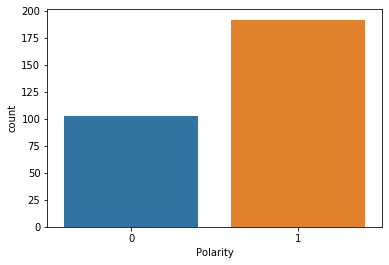

In [637]:
sns.countplot(df_exclamation['Polarity'])

df_exclamation['Polarity'].value_counts(normalize=True)